# Advanced DL and RL: Домашнее задание 2

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

In [1]:
import gym
import numpy as np
from collections import defaultdict

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
class TicTacToe(gym.Env):
    # crosses, noughts
    def __init__(self, n_rows=3, n_cols=3, n_win=3, reward=1):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win
        self.reward = reward

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.cur_turn = 1  # ход первого игрока
        self.reset()

    def get_empty_spaces(self):
        x_axis, y_axis = np.where(self.board == 0)
        return np.array(list(zip(x_axis, y_axis)))

    def _make_move(self, player, i, j):
        if self.board[i, j] != 0:
            raise ValueError('This cell is not empty')
        self.board[i, j] = player

    def get_hash(self):
        return ''.join(map(str, self.board.flatten() + 1))

    def get_identical_states(self):
        def pos_identical(x, y):
            """ np.rot90(A, 0) """
            return x, y

        def pos_rot90(x, y):
            """ np.rot90(A, 1) """
            return y, self.n_cols - 1 - x

        def pos_rot180(x, y):
            """ np.rot90(A, 2) """
            return self.n_rows - 1 - x, self.n_cols - 1 - y

        def pos_rot270(x, y):
            """ np.rot90(A, 3) """
            return self.n_rows - 1 - y, x

        def pos_flip(x, y):
            """ np.flip(A, axis=1) """
            return x, self.n_cols - 1 - y

        def pos_flip_rot90(x, y):
            """ np.rot90(np.flip(A, axis=1), 1) """
            return pos_flip(*pos_rot90(x, y))

        def pos_flip_rot180(x, y):
            """ np.rot90(np.flip(A, axis=1), 2) """
            return pos_flip(*pos_rot180(x, y))

        def pos_flip_rot270(x, y):
            """ np.rot90(np.flip(A, axis=1), 3) """
            return pos_flip(*pos_rot270(x, y))

        states_generator = (
            (np.rot90(self.board, 0), pos_identical),
            (np.rot90(self.board, 1), pos_rot90),
            (np.rot90(self.board, 2), pos_rot180),
            (np.rot90(self.board, 3), pos_rot270),
            (np.flip(self.board, axis=1), pos_flip),
            (np.rot90(np.flip(self.board, axis=1), 1), pos_flip_rot90),
            (np.rot90(np.flip(self.board, axis=1), 2), pos_flip_rot180),
            (np.rot90(np.flip(self.board, axis=1), 3), pos_flip_rot270),
        )

        return states_generator

    def is_terminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.cur_turn), self.cur_turn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                        win = True
            if win:
                return self.reward, True

        if len(self.get_empty_spaces()) == 0:
            return 0, True

        return 0, False

    def print_board(self):
        int_to_marker = {1: 'x', -1: 'o', 0: ' '}
        separator_line = '----' * self.n_cols + '-'

        for line in self.board:
            out = '| ' + ' | '.join([int_to_marker[x] for x in line]) + ' | '
            print(separator_line)
            print(out)
        print(separator_line)

    def get_state(self):
        return self.get_hash(), self.get_empty_spaces(), self.cur_turn

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.get_state(), -10, True

        self._make_move(self.cur_turn, action[0], action[1])
        reward, is_game_over = self.is_terminal()
        self.cur_turn = -self.cur_turn
        return self.get_state(), reward, is_game_over

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.cur_turn = 1

Разные состояния доски могут быть идентичны относительно поворотов, отражения и их комбинаций. Мною было посчитано, что до 8 состояний эквивалентны друг другу. Можно ускорить обучение, рассматривая только одно из эквивалентных состояний, но оказалось, что это не совсем легко сделать, проще обучать как есть.

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [3]:
class Agent:
    def __init__(self):
        self.Q = dict()
        
    def choose_action(self, board, n_actions, is_train=False):
        if board in self.Q:
            action_idx = np.argmax(self.Q[board])

        else:
            action_idx = np.random.randint(n_actions)
            if is_train:
                self.Q[board] = np.zeros(n_actions)

        return action_idx
    
    def choose_eps_greedy_action(self, board, n_actions, eps, is_train=True):
        if board in self.Q and np.random.random() > eps:
            action_idx = np.argmax(self.Q[board])

        else:
            action_idx = np.random.randint(n_actions)
            if board not in self.Q and is_train:
                self.Q[board] = np.zeros(n_actions) - 100
                
        return action_idx

Нужно обучать две модели сразу, но у крестиков большое преимущество из-за первого хода. Для поля 3х3 даже есть просчитанная победная стратегия. Чтобы стратегия для ноликов тоже обучалась, нужно позволять давать случайные ходы.

In [4]:
def Q_learning_episode(env, agent_1, agent_2, alpha=0.01, eps=0.5, gamma=1.0):
    env.reset()
    board, actions, cur_agent = env.get_state()
    reward, done = 0, False
    
    agent_1_prev_board  = None
    agent_1_prev_action = None
    agent_2_prev_board  = None
    agent_2_prev_action = None
    
    while not done:
        n_actions = len(actions)
        if cur_agent == 1:  # crosses
            # choose action
            action_idx = agent_1.choose_eps_greedy_action(board, n_actions, eps)
            action = actions[action_idx]

            # make step
            next_state, reward, done = env.step(action)
            next_board, next_actions, next_agent = next_state
            
            # update noughts Q function
            if agent_2_prev_board is not None:
                prev_Q_value = agent_2.Q[agent_2_prev_board][agent_2_prev_action]
                next_max_Q_value = agent_2.Q[next_board].max() if next_board in agent_2.Q else 0
                new_Q_value = prev_Q_value + alpha * (reward + gamma * next_max_Q_value - prev_Q_value)
                agent_2.Q[agent_2_prev_board][agent_2_prev_action] = new_Q_value

            # if crosses won by this action
            if reward == env.reward:
                agent_1.Q[board][action_idx] = reward

            agent_1_prev_board = board
            agent_1_prev_action = action_idx

        else:  # noughts
            # choose action
            action_idx = agent_2.choose_eps_greedy_action(board, n_actions, eps)
            action = actions[action_idx]
            
            # make step
            next_state, reward, done = env.step(action)
            next_board, next_actions, next_agent = next_state
            
            # update crosses Q function
            if agent_1_prev_board is not None:
                prev_Q_value = agent_1.Q[agent_1_prev_board][agent_1_prev_action]
                next_max_Q_value = agent_1.Q[next_board].max() if next_board in agent_1.Q else 0
                new_Q_value = prev_Q_value + alpha * (reward + gamma * next_max_Q_value - prev_Q_value)
                agent_1.Q[agent_1_prev_board][agent_1_prev_action] = new_Q_value
                
            # if noughts won by this action
            if reward == env.reward:
                agent_2.Q[board][action_idx] = reward

            agent_2_prev_board = board
            agent_2_prev_action = action_idx

        board, actions, cur_agent = next_board, next_actions, next_agent

Мы можем обновлять оценку состояний только после следующего игрока

In [5]:
def play_test_game(env, agent_1=None, agent_2=None):
    env.reset()
    board, actions, cur_agent = env.get_state()

    while True:
        n_actions = len(actions)

        # choose action
        if cur_agent == 1:
            if agent_1 is None:
                action_idx = np.random.randint(n_actions)
            else:
                action_idx = agent_1.choose_action(board, n_actions)
        else:
            if agent_2 is None:
                action_idx = np.random.randint(n_actions)
            else:
                action_idx = agent_2.choose_action(board, n_actions)

        # make step
        action = actions[action_idx]
        next_state, reward, done = env.step(action)
        
        if done:
            return reward, cur_agent

        board, actions, cur_agent = next_state
        
        
def evaluate(env, agent_1=None, agent_2=None, n_episodes=200):
    total_reward = defaultdict(int)
    for _ in range(n_episodes):
        reward, cur_agent = play_test_game(env, agent_1, agent_2)
        total_reward[cur_agent] += reward
        
    crosses_avg_reward = total_reward.get(1, 0) / n_episodes
    noughts_avg_reward = total_reward.get(-1, 0) / n_episodes
    return crosses_avg_reward, noughts_avg_reward


def plot_results(ids, crosses, noughts, figsize=(15, 7)):
    plt.figure(figsize=figsize)
    plt.plot(ids, crosses, label='X')
    plt.plot(ids, noughts, label='O')
    plt.xlabel('learning iterations')
    plt.ylabel('win rate')
    plt.legend()
    plt.show()

In [6]:
def Q_learning(env, agent_1, agent_2, n_episods, test_frequency, eps=0.7):
    iters = []
    crosses = []
    noughts = []
    
    for idx in tqdm(range(1, n_episods + 1)):
        Q_learning_episode(env, agent_1, agent_2, eps=eps)

        if idx % test_frequency == 0:
            crosses_reward, _ = evaluate(env, agent_1, None, 200)
            _, noughts_reward = evaluate(env, None, agent_2, 200)

            iters.append(idx)
            crosses.append(crosses_reward)
            noughts.append(noughts_reward)
            
    return iters, crosses, noughts

In [7]:
tic_tac_toe_env = TicTacToe()
crosses_agent = Agent()
noughts_agent = Agent()


iters, crosses, noughts = Q_learning(
    tic_tac_toe_env,
    crosses_agent,
    noughts_agent,
    n_episods=1_000_000,
    test_frequency=2_500,
)

100%|██████████| 1000000/1000000 [12:19<00:00, 1352.59it/s]


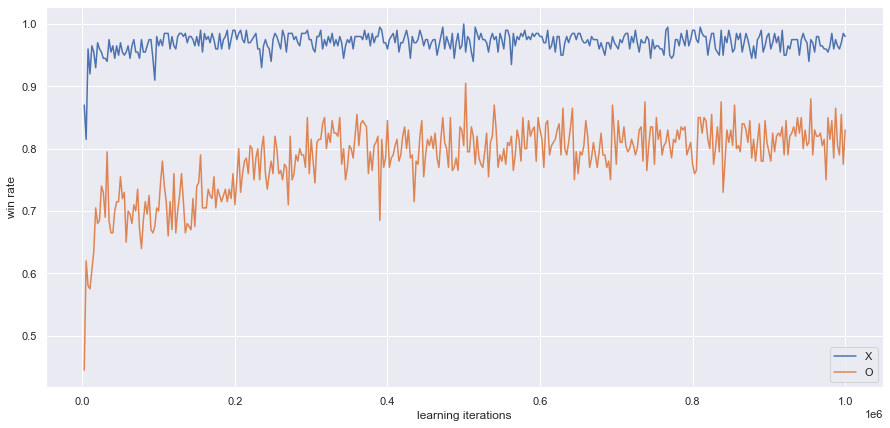

In [8]:
plot_results(iters, crosses, noughts)

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [9]:
tic_tac_toe_env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
crosses_agent = Agent()
noughts_agent = Agent()


iters, crosses, noughts = Q_learning(
    tic_tac_toe_env,
    crosses_agent,
    noughts_agent,
    n_episods=1_000_000,
    test_frequency=2_500,
)

100%|██████████| 1000000/1000000 [37:25<00:00, 445.29it/s] 


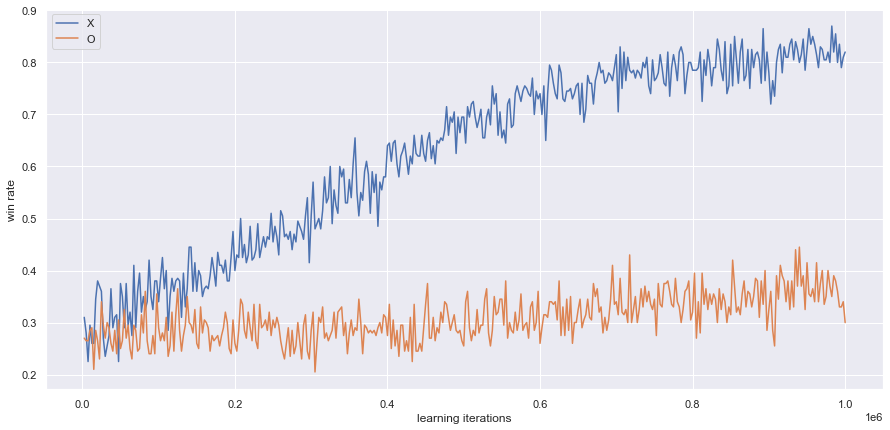

In [10]:
plot_results(iters, crosses, noughts)

### Доска 5х5, 4 в ряд

In [11]:
tic_tac_toe_env = TicTacToe(n_rows=5, n_cols=5, n_win=4)
crosses_agent = Agent()
noughts_agent = Agent()


iters, crosses, noughts = Q_learning(
    tic_tac_toe_env,
    crosses_agent,
    noughts_agent,
    n_episods=1_000_000,
    test_frequency=2_500,
)

100%|██████████| 1000000/1000000 [1:18:47<00:00, 211.54it/s]


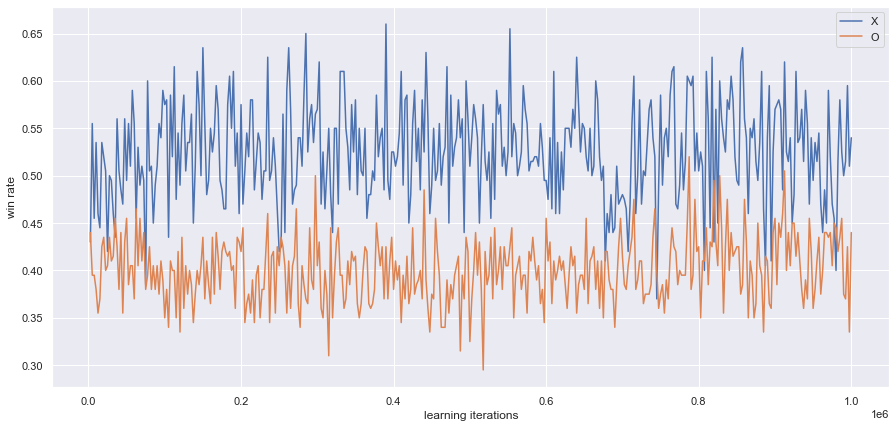

In [12]:
plot_results(iters, crosses, noughts)

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.


## Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


## Часть четвёртая, опциональная: AlphaZero
В опциональной части домашнего задания давайте попробуем всё-таки собрать всё вместе и завести настоящий AlphaZero. Если получится и будет обобщаться на большие доски, будет очень круто и будет стоить много дополнительных баллов.

7. Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).
